In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, TimeDistributed, Dropout, MaxPooling1D, MaxPooling2D, Conv2D, Input, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from scipy.stats import kurtosis, skew
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import itertools

In [163]:
def disp2vel(disp,dt):
    vel = np.zeros(disp.shape)
    vel[:,1:] = (disp[:,1:]-disp[:,0:-1])/dt
    vel[:,0] = -2*vel[:,0]+vel[:,1]
    return vel

def vel2acc(vel,dt):
    acc = np.zeros(vel.shape)
    acc[:,1:] = (vel[:,1:]-vel[:,0:-1])/dt
    acc[:,0] = -2*acc[:,0]+acc[:,1]
    return acc

def acc2vel(acc,dt):
    vel = np.zeros(acc.shape)
    for i in range(0,vel.shape[1]-1):
        vel[:,i+1] = vel[:,i]+1/2*(acc[:,i+1]+acc[:,i])*dt
    print(i)
    return vel

def vel2disp(vel,dt):
    disp = np.zeros(vel.shape)
    for i in range(1,disp.shape[1]-1):
        disp[:,i+1] = disp[:,i]+1/2*(vel[:,i+1]+vel[:,i])*dt
    return disp

In [3]:
mat = scipy.io.loadmat('test2010.mat')

In [4]:
chan_names = mat['chan_names']
data = mat['data']

In [5]:
D = 0.027

t1 = 15
t2 = 165
Fs = 1200
dt = 1/Fs
tst = t1*Fs
ted = t2*Fs

nm = data.shape[1]
time = np.arange(0,nm-1)*dt
time = time[tst:ted].reshape(1,-1)

strain_CF = data[46:70,tst:ted]
strain_IL = data[6:46,tst:ted]
pos_IL = data[98:106,tst:ted]
pos_CF = data[106:114,tst:ted]
acc_IL = data[70:78,tst:ted]
acc_CF = data[78:86,tst:ted]

# Strain sensor positions
str_il = np.array([1.143,2.555,3.084,3.224,4.155,5.759,6.030,7.664,8.216,8.609,8.889,9.703,10.285,13.676,13.772,
                     15.393,16.452,16.547,16.891,19.997,20.193,21.393,21.603,22.460,23.165,25.153,25.442,26.254,27.532,
                     28.698,28.863,29.365,31.191,31.415,32.796,33.005,35.549,36.559,36.824,37.322])
str_sensor_cf = np.array([2,3,4,5,7,10,11,13,14,17,19,20,21,22,24,25,26,28,31,32,33,36,38,40])-1
str_cf = str_il[str_sensor_cf]

# Accelerometer positions
acc_pos = np.array([4.155,8.609,13.676,16.891,21.393,25.153,28.863,33.005])

# Finding indices for strain locations which will be fused 
sensor_diff_il = np.abs(np.tile(str_il,(8,1)).T - acc_pos)
sensor_transform_index_il = np.argmin(sensor_diff_il,axis=1)

sensor_diff_cf = np.abs(np.tile(str_cf,(8,1)).T - acc_pos)
sensor_transform_index_cf = np.argmin(sensor_diff_cf,axis=1)

max_strain_CF = strain_CF.argmax(axis=0)
max_strain_CF_loc = str_cf[max_strain_CF]

In [127]:
#X = np.vstack((time,pos_IL,pos_CF,vel_IL,vel_CF,acc_IL,acc_CF)).transpose()
X = np.vstack((time,acc_IL,acc_CF)).transpose()
#Y = np.vstack((strain_CF.argmax(axis=0),strain_IL.argmax(axis=0))).transpose()
Y = np.vstack(max_strain_CF).transpose()
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

n_features = X.shape[1]
b_size = 100
n_outputs = Y.shape[0]

n_batches = int(X.shape[0]/b_size)
X = X.reshape(n_batches,b_size,n_features)
Y = Y.reshape(n_batches,b_size,n_outputs)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, shuffle=False)

t_train = X_train[:,:,0]
t_val = X_val[:,:,0]
t_test = X_test[:,:,0]
X_train = X_train[:,:,0:-1]
X_test = X_test[:,:,0:-1]
X_val = X_val[:,:,0:-1]


n_features = n_features-1
n_outputs = Y.max()+1

In [128]:
# Classification
model = Sequential(name='LSTM')
model.add(LSTM(
    units=100,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True,
    dropout=0.1,
    recurrent_dropout=0.1,
    activation='tanh'))
model.add(Dense(50,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(n_outputs, activation='softmax'))

model.summary()
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=['SparseCategoricalAccuracy'])

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 100, 100)          46800     
_________________________________________________________________
dense_26 (Dense)             (None, 100, 50)           5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
dense_27 (Dense)             (None, 100, 24)           1224      
Total params: 53,074
Trainable params: 53,074
Non-trainable params: 0
_________________________________________________________________


In [129]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train,y_train,epochs=100,callbacks=callback,validation_data=(X_val, y_val),validation_steps=10)

Epoch 1/100
32/32 [==============================] - 4s 79ms/step - loss: 2.8762 - sparse_categorical_accuracy: 0.1711 - val_loss: 2.3991 - val_sparse_categorical_accuracy: 0.3114
Epoch 2/100
32/32 [==============================] - 2s 69ms/step - loss: 2.3888 - sparse_categorical_accuracy: 0.2873 - val_loss: 2.0077 - val_sparse_categorical_accuracy: 0.4217
Epoch 3/100
32/32 [==============================] - 3s 109ms/step - loss: 2.1848 - sparse_categorical_accuracy: 0.3413 - val_loss: 1.7860 - val_sparse_categorical_accuracy: 0.4793
Epoch 4/100
32/32 [==============================] - 4s 121ms/step - loss: 2.0604 - sparse_categorical_accuracy: 0.3684 - val_loss: 1.6917 - val_sparse_categorical_accuracy: 0.4970
Epoch 5/100
32/32 [==============================] - 4s 120ms/step - loss: 1.9689 - sparse_categorical_accuracy: 0.3913 - val_loss: 1.5914 - val_sparse_categorical_accuracy: 0.5258
Epoch 6/100
32/32 [==============================] - 4s 118ms/step - loss: 1.9020 - sparse_catego

In [130]:
y_pred = model.predict(X_test)
y_pred_amax = y_pred.argmax(axis=2)

In [131]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

15/15 - 0s - loss: 2.0031 - sparse_categorical_accuracy: 0.4022


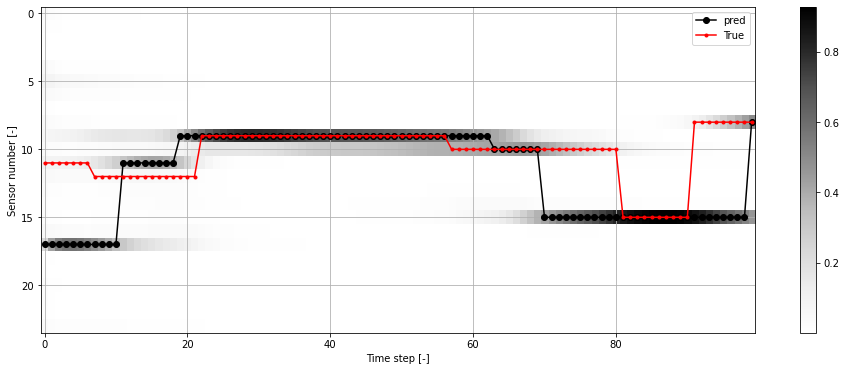

In [176]:
n = 20
plt.figure(figsize=(16,6))
plt.imshow(y_pred[n,:,:].T,cmap='Greys',interpolation='nearest', aspect='auto')
plt.plot(y_pred_amax[n,:],'k-o',label='pred')
plt.plot(y_test[n,:],'r.-',label='True')
plt.colorbar()
plt.legend()
plt.grid()
plt.ylabel('Sensor number [-]')
plt.xlabel('Time step [-]')
plt.show()

Misclassification rate: 0.598
Misclassification due to random guessing: 0.958


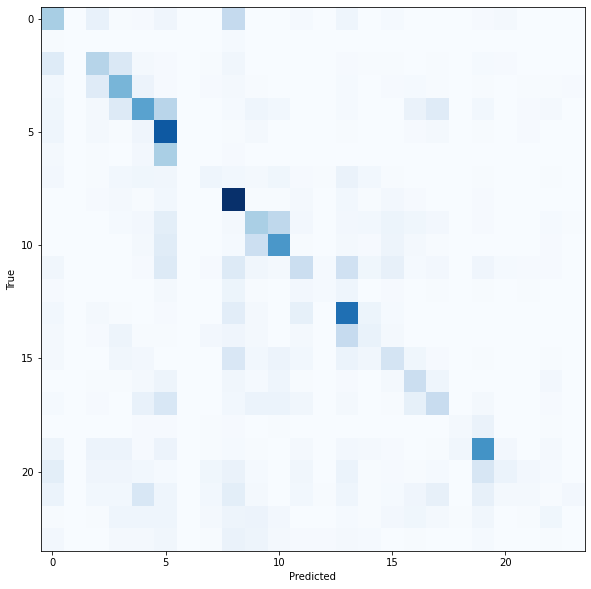

In [165]:
y_p = y_pred_amax.reshape(-1,1)
y_true = y_test.reshape(-1,1)

cm = confusion_matrix(y_true,y_p)
misclassification_rate = 1-np.diagonal(cm).sum()/y_true.shape[0]
print(f'Misclassification rate: {round(misclassification_rate,3)}')
print(f'Misclassification due to random guessing: {round(1-1/len(str_cf),3)}')

plt.figure(figsize=(10,10))
plt.imshow(cm,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

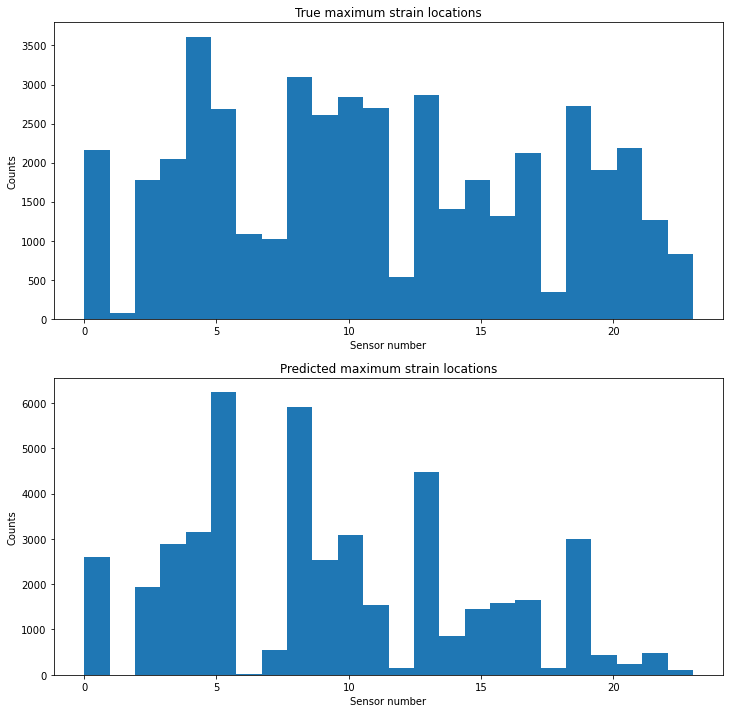

In [167]:
fig, ax = plt.subplots(2,figsize=(12,12))
ax[0].hist(y_true,bins=24)
ax[1].hist(y_p,bins=24)
ax[0].set_xlabel('Sensor number')
ax[1].set_xlabel('Sensor number')
ax[0].set_ylabel('Counts')
ax[1].set_ylabel('Counts')
ax[0].set_title('True maximum strain locations')
ax[1].set_title('Predicted maximum strain locations')
plt.show()